In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from cProfile import label #?not sure
import re
from fuzzywuzzy import fuzz
import difflib 
from fuzzywuzzy import process
import time
from tqdm import tqdm
import fitz

from functools import reduce
from fitz.utils import getColor

/opt/homebrew/lib/python3.10/site-packages/fuzzywuzzy/fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


In [2]:
vol1_path = '../input/NOUVELLE FLORE DU LIBAN ET DE LA SYRIE 1.pdf'
vol2_path = '../input/NOUVELLE FLORE DU LIBAN ET DE LA SYRIE 2.pdf'
vol3_path = '../input/NOUVELLE FLORE DU LIBAN ET DE LA SYRIE 3.pdf'

vol1_doc = fitz.open(vol1_path)
vol2_doc = fitz.open(vol2_path)
vol3_doc = fitz.open(vol3_path)

vol1_pages = [vol1_doc[i] for i in range(vol1_doc.page_count)]
vol2_pages = [vol2_doc[i] for i in range(vol2_doc.page_count)]
vol3_pages = [vol3_doc[i] for i in range(vol3_doc.page_count)]

In [3]:
vol1_char_df = pd.read_pickle("../input/char_df/vol1_df.pkl")
vol2_char_df = pd.read_pickle("../input/char_df/vol2_df.pkl")
vol3_char_df = pd.read_pickle("../input/char_df/vol3_df.pkl")

In [4]:
#mout. index: 
vol1_index_path = '../output/local/index_output/vol1_nonitalics.csv'
vol2_index_path = '../output/local/index_output/vol2_nonitalics.csv'
vol3_index_path = '../output/local/index_output/vol3_nonitalics.csv'

vol1_index_df = pd.read_csv(vol1_index_path)
vol2_index_df = pd.read_csv(vol2_index_path)
vol3_index_df = pd.read_csv(vol3_index_path)

#changing name of columns of mout. indecies 
vol1_index_df.rename(columns={'closest_genus': 'mouterde_genus', 'closest_epithet': 'mouterde_epithet', 'authors':'mouterde_author', 'closest_infra_name':'mouterde_infra'}, inplace=True)
vol2_index_df.rename(columns={'closest_genus': 'mouterde_genus', 'closest_epithet': 'mouterde_epithet', 'authors':'mouterde_author', 'closest_infra_name':'mouterde_infra'}, inplace=True)
vol3_index_df.rename(columns={'closest_genus': 'mouterde_genus', 'closest_epithet': 'mouterde_epithet', 'authors':'mouterde_author', 'closest_infra_name':'mouterde_infra'}, inplace=True)

In [5]:
vol1_word_df = vol1_char_df.loc[:, ['vol_num', 'page_num', 
                                    'block_num', 'block_num_absolute', 'block_bbox',
                                    'line_num', 'line_wmode', 'line_dir', 'line_bbox', 
                                    'span_num', 'span_size', 'span_flags', 'span_font', 'span_color', 'span_ascender', 'span_descender', 'span_origin', 'span_bbox', 
                                    'word_num', 'word','word_bbox', 'pruned_word', 'pruned_word_bbox']].drop_duplicates()

vol2_word_df = vol2_char_df.loc[:, ['vol_num', 'page_num', 
                                    'block_num', 'block_num_absolute', 'block_bbox',
                                    'line_num', 'line_wmode', 'line_dir', 'line_bbox', 
                                    'span_num', 'span_size', 'span_flags', 'span_font', 'span_color', 'span_ascender', 'span_descender', 'span_origin', 'span_bbox', 
                                    'word_num', 'word','word_bbox', 'pruned_word', 'pruned_word_bbox']].drop_duplicates()

vol3_word_df = vol3_char_df.loc[:, ['vol_num', 'page_num', 
                                    'block_num', 'block_num_absolute', 'block_bbox',
                                    'line_num', 'line_wmode', 'line_dir', 'line_bbox', 
                                    'span_num', 'span_size', 'span_flags', 'span_font', 'span_color', 'span_ascender', 'span_descender', 'span_origin', 'span_bbox', 
                                    'word_num', 'word','word_bbox', 'pruned_word', 'pruned_word_bbox']].drop_duplicates()

In [6]:
#list of genera from index -- uppercased to match main text pattern
vol1_genera = vol1_index_df[vol1_index_df['taxon_rank'] == 'genus']['mouterde_genus'].str.upper().tolist()

#list of species binomial from main text
vol1_species_temp_df = vol1_index_df[(vol1_index_df['taxon_rank'] == 'epithet') & (~vol1_index_df['mouterde_genus'].isna())]
vol1_species_binomial_list = list(zip(vol1_species_temp_df['mouterde_genus'], vol1_species_temp_df['mouterde_epithet']))
vol1_species = list(map(lambda x: f"{x[0]} {x[1]}", vol1_species_binomial_list))
vol1_species_abriviation = list(map(lambda x: f"{x[0][0]}. {x[1]}", vol1_species_binomial_list))

In [7]:
def is_italic(flags):
    return flags & 2 ** 1 != 0

In [8]:
def get_n_words_flagged(df, n, inplace = True):
    #assumes n > 1
    out_words_col = f"{n}_words"
    out_flags_col = f"{n}_flags"
    
    line_group_cols = ['vol_num', 'page_num', 
                       'block_num', 'block_num_absolute', 'block_bbox', 
                       'line_num', 'line_wmode', 'line_dir', 'line_bbox']
    
    n_words_lists = [None for i in range(n)]
    n_words_flags = [None for i in range(n)]

    n_words_lists[0] = df['word']
    n_words_flags[0] = df['span_flags']

    for i in range(1, n):
        n_words_lists[i] = df.groupby(line_group_cols)['word'].shift(-i, fill_value="")
        n_words_flags[i] = df.groupby(line_group_cols)['span_flags'].shift(-i, fill_value=0)

    zip_n_words = list(zip(*n_words_lists))
    n_word_string = list(map(lambda n_word_list : " ".join(n_word_list), zip_n_words))

    zip_n_flags = list(zip(*n_words_flags))
    combine_flags = list(map(lambda flag_list : reduce(lambda x, y: x | y, flag_list), zip_n_flags))
    
    if inplace == True:
        df[out_words_col] = n_word_string
        df[out_flags_col] = combine_flags
    return n_word_string, combine_flags

In [9]:
tqdm.pandas()

In [10]:
vol1_word_df = pd.read_pickle("../input/desc_box_df/vol1_desc_df_v2.pkl")

In [11]:
vol1_word_df.columns

Index(['vol_num', 'page_num', 'block_num', 'block_num_absolute', 'block_bbox',
       'line_num', 'line_wmode', 'line_dir', 'line_bbox', 'span_num',
       'span_size', 'span_flags', 'span_font', 'span_color', 'span_ascender',
       'span_descender', 'span_origin', 'span_bbox', 'word_num', 'word',
       'word_bbox', 'pruned_word', 'pruned_word_bbox', '1_words', '1_flags',
       '1_words_match', '1_words_match_score', '2_words', '2_flags',
       '2_words_match', '2_words_match_score', '3_words', '3_flags',
       '3_words_match', '3_words_match_score', '4_words', '4_flags',
       '4_words_match', '4_words_match_score', 'line_id', 'is_page_title',
       'page_title_mean_y', 'is_title_line', 'section_break', 'section_id',
       'section_start_y', 'section_bbox', 'binom_section'],
      dtype='object')

In [12]:
is_binomial = ((~(vol1_word_df['1_flags'].apply(is_italic)) & (vol1_word_df['1_words_match_score'] > 0.85)) | 
               (~(vol1_word_df['2_flags'].apply(is_italic)) & (vol1_word_df['2_words_match_score'] > 0.85)) | 
               (~(vol1_word_df['3_flags'].apply(is_italic)) & (vol1_word_df['3_words_match_score'] > 0.85)) | 
               (~(vol1_word_df['1_flags'].apply(is_italic)) & (vol1_word_df['1_words_match_score'] > 0.85))) 
binom_page_num = vol1_word_df[(is_binomial)]['page_num']
binom_block_num = vol1_word_df[(is_binomial)]['block_num']
binom_line_num = vol1_word_df[(is_binomial)]['line_num']
binom_id = list(zip(binom_page_num, binom_block_num, binom_line_num))

In [13]:
vol1_char_df['line_id'] = vol1_char_df.apply(lambda r : (r['page_num'], r['block_num'], r['line_num']), axis = 1)
vol1_char_binom_df = vol1_char_df[vol1_char_df['line_id'].isin(binom_id)]

In [14]:
binom_char_width = vol1_char_binom_df.groupby('line_id')['char_bbox'].transform(lambda x: x.apply(lambda y: y[2] - y[0])).mean()
binom_char_width

4.925233924113611

In [15]:
num_pages = vol1_word_df['page_num'].max() + 1
for page_num in tqdm(range(num_pages)):
    vol1_word_df.loc[vol1_word_df['page_num'] == page_num, 'mean_binom_x0'] = vol1_word_df[(vol1_word_df['page_num'] == page_num) & (vol1_word_df['line_id'].isin(binom_id))]['line_bbox'].apply(lambda x : x[0]).mean()

100%|██████████| 642/642 [00:06<00:00, 98.22it/s]


In [16]:
accepted_error = (binom_char_width)*2.5 #just eyeballing it ...

def is_binom_indentation(row):
    if abs(row['mean_binom_x0'] - (row['line_bbox'][0])) < accepted_error:
        return True
    else:
        return False

vol1_word_df['is_binom_indentation'] = vol1_word_df.progress_apply(is_binom_indentation, axis = 1)

100%|██████████| 314517/314517 [00:01<00:00, 217218.50it/s]


In [17]:
vol1_word_df['section_break']

0          False
6          False
14         False
16         False
20         False
           ...  
1761774     True
1761781     True
1761784     True
1761788     True
1761792     True
Name: section_break, Length: 314517, dtype: bool

In [18]:
vol1_word_df['paragraph_id'] = np.nan
def paragraph_id(row):
    if row['is_binom_indentation'] == True:
        return row['line_id']
    if row['section_break'] == True:
        return row['line_id']
    else:
        return np.nan

vol1_word_df['paragraph_id'] = vol1_word_df.progress_apply(paragraph_id, axis = 1)
vol1_word_df['paragraph_id'].ffill(inplace=True)

100%|██████████| 314517/314517 [00:01<00:00, 219756.66it/s]


In [19]:
# break down line coords
vol1_word_df['line_x0'] = vol1_word_df["line_bbox"].apply(lambda x: x[0])
vol1_word_df['line_y0'] = vol1_word_df["line_bbox"].apply(lambda x: x[1])
vol1_word_df['line_x1'] = vol1_word_df["line_bbox"].apply(lambda x: x[2])
vol1_word_df['line_y1'] = vol1_word_df["line_bbox"].apply(lambda x: x[3])

#sections_coords: 
vol1_word_df["paragraph_x0"] = vol1_word_df.groupby(['page_num', 'paragraph_id'])['line_x0'].transform('min')
vol1_word_df["paragraph_y0"] = vol1_word_df.groupby(['page_num', 'paragraph_id'])['line_y0'].transform('min')
#vol1_word_df["section_y0"] = vol1_word_df[['section_y0_all','section_y0_all']].max(axis=1)
vol1_word_df["paragraph_x1"] = vol1_word_df.groupby(['page_num', 'paragraph_id'])['line_x1'].transform('max')
vol1_word_df["paragraph_y1"] = vol1_word_df.groupby(['page_num', 'paragraph_id'])['line_y1'].transform('max')

#section_bbox:
vol1_word_df["paragraph_bbox"] = vol1_word_df.apply(lambda r: (r["paragraph_x0"], r["paragraph_y0"], r["paragraph_x1"], r["paragraph_y1"]), axis = 1)

#drop extra cols:
vol1_word_df.drop(columns= ["line_x0", "line_y0", "line_x1", "line_y1", "paragraph_x0", "paragraph_y0", "paragraph_x1", "paragraph_y1"], inplace = True)

In [22]:
vol1_doc = fitz.open(vol1_path)
vol2_doc = fitz.open(vol2_path)
vol3_doc = fitz.open(vol3_path)

for page_num in tqdm(range(num_pages)):
    section_groups = vol1_word_df[vol1_word_df['page_num'] == page_num].groupby('section_id')
    page = vol1_doc[page_num]
    colors = [getColor("plum"), getColor("orchid4")]
    
    paragraph_groups = vol1_word_df[vol1_word_df['page_num'] == page_num].groupby('paragraph_id')
    for name, paragraph in paragraph_groups:
        i = 0
        paragraph_id = paragraph.iloc[0]['paragraph_id']
        paragraph_section_id = paragraph.iloc[0]['section_id']
        paragraph_bbox = paragraph.iloc[0]['paragraph_bbox']
        is_L_loc = paragraph.iloc[0]['word'].lower() in ["l.", "l"]
        is_S_loc = paragraph.iloc[0]['word'].lower() in ["s.", "s"]
        
        c = getColor("lightgray")
        if is_L_loc: 
            c = getColor("lightblue")
        if is_S_loc:
            c = getColor("pink")
        if paragraph_section_id in binom_id:
            r_box = fitz.Rect(paragraph_bbox)
            annot_rect = page.add_rect_annot(r_box)
            annot_rect.set_colors({"stroke":c})
            annot_rect.update()
            i += 1
        c = getColor("lightgray")

    for name, section in section_groups:
        section_id = section.iloc[0]['section_id']
        section_bbox = section.iloc[0]['section_bbox']
        if section_id in binom_id:
            r_box = fitz.Rect(section_bbox)
            #r_box.set_stroke_color(stroke=getColor("violetred4"))
            annot_rect = page.add_rect_annot(r_box)
            annot_rect.set_colors({"stroke": getColor("violetred4")})
            annot_rect.update()

marked_epithet_fname = "../output/local/main_text/binom_sections_paragraphs_LS_v1.pdf"
vol1_doc.save(marked_epithet_fname)

100%|██████████| 642/642 [00:03<00:00, 184.48it/s]


### current problems

page 110 -- no binom in page -- not catagorizing paragraphs as expected / hoped
page 275 -- above ^ 
page 97 -- L. et S. 
page 107 -- 2.5 error margin seems too wide ... 
page 127 -- Phalaris caerulescens -> . L. Ct. ....
what to do with stuff like 153 
how important is italics entries being in good entries (eg 160)

265 is being picked up correctly which is *happy*
271 sy. Sy. «Tell près de Zraikiyé, au nord de Sanamein», décembre 1954 (Hauran). Legit PABOT. Typus: Herbier Mouterde P 326

real issue : 276 : start of binomial issue: "'-^ Juncus effusus 
-- possible solution: for binomial x0, go based on word x0 for part that is the  
                      binomial matching part not the line match
-- possible solution for pages without binomials: add a column to keep track of distance 
                                                  between bbox and binomial name x0 (first solve above) and take the average of that value as binomial x0 then add that to the desired page's section bbox x0 


box problem -- 308 ??? 

216 -- var. situation
217 -- L.-S. Frontière libano-syrienne de Jdeidet Yabous (Pr, Mt).


In [21]:
vol1_word_df.columns

Index(['vol_num', 'page_num', 'block_num', 'block_num_absolute', 'block_bbox',
       'line_num', 'line_wmode', 'line_dir', 'line_bbox', 'span_num',
       'span_size', 'span_flags', 'span_font', 'span_color', 'span_ascender',
       'span_descender', 'span_origin', 'span_bbox', 'word_num', 'word',
       'word_bbox', 'pruned_word', 'pruned_word_bbox', '1_words', '1_flags',
       '1_words_match', '1_words_match_score', '2_words', '2_flags',
       '2_words_match', '2_words_match_score', '3_words', '3_flags',
       '3_words_match', '3_words_match_score', '4_words', '4_flags',
       '4_words_match', '4_words_match_score', 'line_id', 'is_page_title',
       'page_title_mean_y', 'is_title_line', 'section_break', 'section_id',
       'section_start_y', 'section_bbox', 'binom_section', 'mean_binom_x0',
       'is_binom_indentation', 'paragraph_id', 'paragraph_bbox'],
      dtype='object')

In [23]:
vol1_word_df['pruned_word']

0               AUTRES
6             OUVRAGES
14                  DU
16                MÊME
20              AUTEUR
              ...     
1761774        JUILLET
1761781            MIL
1761784           NEUF
1761788           CENT
1761792    SOIXANTESIX
Name: pruned_word, Length: 314517, dtype: object

In [24]:
[getColor("darkpink"), getColor("lightblue")]

[(1, 1, 1), (0.6784313725490196, 0.8470588235294118, 0.9019607843137255)]

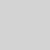

In [25]:
from PIL import Image

# Create a new image with a solid color
width = 50
height = 50
colors = [getColor("pink"), getColor("lightblue"),  getColor("lightgray")]
for color_1 in colors:
    color_255 = tuple(int(c_val*255) for c_val in color_1) # red color
    image = Image.new("RGB", (width, height), color_255)
    image.show()
# Display the image
image

### parse L. and S. 

In [26]:
paragraph_groups = vol1_word_df.groupby('paragraph_id')
vol1_word_df['paragraph_word_num'] = paragraph_groups.cumcount() + 1
paragraph_groups_123 = vol1_word_df[vol1_word_df['page_num'] == 123].groupby('paragraph_id')

for name, paragraph in paragraph_groups_123:
    is_L_loc = paragraph.iloc[0]['word'].lower() in ["l.", "l"]
    if is_L_loc:
        break

In [27]:
# checking if paragraph_word_num works correctly when section paragraph acrros 2 pages accross
HC_id = vol1_word_df[vol1_word_df['4_words'] == "Heteropogon con tort us"]['paragraph_id'].iloc[0]
vol1_word_df[(vol1_word_df['paragraph_id'] == HC_id)]['paragraph_word_num']

324225      1.0
324236      2.0
324239      3.0
324243      4.0
324245      5.0
          ...  
325194    167.0
325204    168.0
325206    169.0
325209    170.0
325211    171.0
Name: paragraph_word_num, Length: 171, dtype: float64

In [28]:
" ".join(paragraph['word'])

"L. Ct. Echelles de Tyr (P), Iskandérouné (Bl), Beyrouth et environs (Bl, Vt, P, Np, Mt, Pb), Zouk Mikhayel (Mt), Chekka (Pb), Tripoli (Bl). Mi. 'Abey (P), Jamhour (Mt), 'Aley (Pb), Kahalé, Ghazir (Gb), Deir-el-Qamar (J.L.), Broummana (Bnm)."

In [29]:
paragraph

,vol_num,page_num,block_num,block_num_absolute,block_bbox,line_num,line_wmode,line_dir,line_bbox,span_num,...,section_break,section_id,section_start_y,section_bbox,binom_section,mean_binom_x0,is_binom_indentation,paragraph_id,paragraph_bbox,paragraph_word_num
323515,1,123,10,22,"(47.7599983215332, 322.4200134277344, 415.2171...",0,0,"(1.0, 0.0)","(47.7599983215332, 322.4200134277344, 415.2171...",0,...,False,"(123, 5, 0)",119.350006,"(29.520000457763672, 119.35000610351562, 415.6...",False,51.24,True,"(123, 10, 0)","(29.760000228881836, 322.4200134277344, 415.21...",1.0
323517,1,123,10,22,"(47.7599983215332, 322.4200134277344, 415.2171...",0,0,"(1.0, 0.0)","(47.7599983215332, 322.4200134277344, 415.2171...",1,...,False,"(123, 5, 0)",119.350006,"(29.520000457763672, 119.35000610351562, 415.6...",False,51.24,True,"(123, 10, 0)","(29.760000228881836, 322.4200134277344, 415.21...",2.0
323520,1,123,10,22,"(47.7599983215332, 322.4200134277344, 415.2171...",0,0,"(1.0, 0.0)","(47.7599983215332, 322.4200134277344, 415.2171...",2,...,False,"(123, 5, 0)",119.350006,"(29.520000457763672, 119.35000610351562, 415.6...",False,51.24,True,"(123, 10, 0)","(29.760000228881836, 322.4200134277344, 415.21...",3.0
323528,1,123,10,22,"(47.7599983215332, 322.4200134277344, 415.2171...",0,0,"(1.0, 0.0)","(47.7599983215332, 322.4200134277344, 415.2171...",2,...,False,"(123, 5, 0)",119.350006,"(29.520000457763672, 119.35000610351562, 415.6...",False,51.24,True,"(123, 10, 0)","(29.760000228881836, 322.4200134277344, 415.21...",4.0
323530,1,123,10,22,"(47.7599983215332, 322.4200134277344, 415.2171...",0,0,"(1.0, 0.0)","(47.7599983215332, 322.4200134277344, 415.2171...",2,...,False,"(123, 5, 0)",119.350006,"(29.520000457763672, 119.35000610351562, 415.6...",False,51.24,True,"(123, 10, 0)","(29.760000228881836, 322.4200134277344, 415.21...",5.0
323533,1,123,10,22,"(47.7599983215332, 322.4200134277344, 415.2171...",0,0,"(1.0, 0.0)","(47.7599983215332, 322.4200134277344, 415.2171...",2,...,False,"(123, 5, 0)",119.350006,"(29.520000457763672, 119.35000610351562, 415.6...",False,51.24,True,"(123, 10, 0)","(29.760000228881836, 322.4200134277344, 415.21...",6.0
323537,1,123,10,22,"(47.7599983215332, 322.4200134277344, 415.2171...",0,0,"(1.0, 0.0)","(47.7599983215332, 322.4200134277344, 415.2171...",2,...,False,"(123, 5, 0)",119.350006,"(29.520000457763672, 119.35000610351562, 415.6...",False,51.24,True,"(123, 10, 0)","(29.760000228881836, 322.4200134277344, 415.21...",7.0
323549,1,123,10,22,"(47.7599983215332, 322.4200134277344, 415.2171...",0,0,"(1.0, 0.0)","(47.7599983215332, 322.4200134277344, 415.2171...",3,...,False,"(123, 5, 0)",119.350006,"(29.520000457763672, 119.35000610351562, 415.6...",False,51.24,True,"(123, 10, 0)","(29.760000228881836, 322.4200134277344, 415.21...",8.0
323554,1,123,10,22,"(47.7599983215332, 322.4200134277344, 415.2171...",0,0,"(1.0, 0.0)","(47.7599983215332, 322.4200134277344, 415.2171...",4,...,False,"(123, 5, 0)",119.350006,"(29.520000457763672, 119.35000610351562, 415.6...",False,51.24,True,"(123, 10, 0)","(29.760000228881836, 322.4200134277344, 415.21...",9.0
323562,1,123,10,22,"(47.7599983215332, 322.4200134277344, 415.2171...",0,0,"(1.0, 0.0)","(47.7599983215332, 322.4200134277344, 415.2171...",4,...,False,"(123, 5, 0)",119.350006,"(29.520000457763672, 119.35000610351562, 415.6...",False,51.24,True,"(123, 10, 0)","(29.760000228881836, 322.4200134277344, 415.21...",10.0


In [30]:
paragraph_italics_list = (paragraph[paragraph['span_flags'].apply(is_italic)]['paragraph_word_num'] -1).tolist()
paragraph_italics_list.append((paragraph['paragraph_word_num']).max())

sub_loc_dict = {}
paragraph_text = paragraph['word'].tolist()

for i in range(len(paragraph_italics_list) - 1):
    curr_word_i = int(paragraph_italics_list[i])
    next_word_i = int(paragraph_italics_list[i+1]) #only works if the last word of L. is not italics
    sub_loc_italics = paragraph_text[curr_word_i]
    sub_location_list = paragraph_text[curr_word_i + 1: next_word_i]
    sub_location_str = " ".join(sub_location_list)
    # make dict for L. / S. whenever it exists.
    sub_loc_result = [match_s.strip() for match_s in re.findall(r'([^,()]+?)(?=[,(])(?![^()]*\))', sub_location_str)]
    paragraph_section_id = paragraph['section_id'].iloc[0]
    try:
        sub_loc_dict[paragraph_section_id]
    except:
        sub_loc_dict[paragraph_section_id] = {}
    if paragraph_text[0].lower() in ['l.', 'l']:
        try: 
            sub_loc_dict[paragraph_section_id]['L.']
        except: 
            sub_loc_dict[paragraph_section_id]['L.'] = []
        sub_loc_dict[paragraph_section_id]['L.'].append({sub_loc_italics: sub_loc_result})
    if paragraph_text[0].lower() in ['s.', 's']:
        try: 
            sub_loc_dict[paragraph_section_id]['S.']
        except: 
            sub_loc_dict[paragraph_section_id]['S.'] = []
        sub_loc_dict[paragraph_section_id]['S.'].append({sub_loc_italics: sub_loc_result})

In [31]:
sub_loc_dict

{(123,
  5,
  0): {'L.': [{'Ct.': ['Echelles de Tyr',
     'Iskandérouné',
     'Beyrouth et environs',
     'Zouk Mikhayel',
     'Chekka',
     'Tripoli']},
   {'Mi.': ["'Abey",
     'Jamhour',
     "'Aley",
     'Kahalé',
     'Ghazir',
     'Deir-el-Qamar',
     'Broummana']}]}}

In [32]:
sub1 = "Echelles de Tyr (P), Iskandérouné (Bl), Beyrouth et environs (Bl, Vt, P, Np, Mt, Pb), Zouk Mikhayel (Mt), Chekka (Pb), Tripoli (Bl). "
sub2 = "'Abey (P), Jamhour (Mt), 'Aley (Pb), Kahalé, Ghazir (Gb), Deir-el-Qamar (J.L.), Broummana (Bnm). "

In [33]:
[match_s.strip() for match_s in re.findall(r'([^,()]+?)(?=[,(])(?![^()]*\))', sub2)]

["'Abey", 'Jamhour', "'Aley", 'Kahalé', 'Ghazir', 'Deir-el-Qamar', 'Broummana']

In [34]:
paragraph_text

['L.',
 'Ct.',
 'Echelles',
 'de',
 'Tyr',
 '(P),',
 'Iskandérouné',
 '(Bl),',
 'Beyrouth',
 'et',
 'environs',
 '(Bl,',
 'Vt,',
 'P,',
 'Np,',
 'Mt,',
 'Pb),',
 'Zouk',
 'Mikhayel',
 '(Mt),',
 'Chekka',
 '(Pb),',
 'Tripoli',
 '(Bl).',
 'Mi.',
 "'Abey",
 '(P),',
 'Jamhour',
 '(Mt),',
 "'Aley",
 '(Pb),',
 'Kahalé,',
 'Ghazir',
 '(Gb),',
 'Deir-el-Qamar',
 '(J.L.),',
 'Broummana',
 '(Bnm).']

In [35]:
vol1_doc = fitz.open(vol1_path)
vol2_doc = fitz.open(vol2_path)
vol3_doc = fitz.open(vol3_path)

for page_num in tqdm(range(num_pages)):
    section_groups = vol1_word_df[vol1_word_df['page_num'] == page_num].groupby('section_id')
    page = vol1_doc[page_num]
    colors = [getColor("plum"), getColor("orchid4")]
    
    paragraph_groups = vol1_word_df[vol1_word_df['page_num'] == page_num].groupby('paragraph_id')
    for name, paragraph in paragraph_groups:
        i = 0
        paragraph_id = paragraph.iloc[0]['paragraph_id']
        paragraph_section_id = paragraph.iloc[0]['section_id']
        paragraph_bbox = paragraph.iloc[0]['paragraph_bbox']
        is_L_loc = paragraph.iloc[0]['word'].lower() in ["l.", "l"]
        is_S_loc = paragraph.iloc[0]['word'].lower() in ["s.", "s"]
        
        c = getColor("lightgray")
        if is_L_loc: 
            c = getColor("lightblue")
        if is_S_loc:
            c = getColor("pink")
        if paragraph_section_id in binom_id:
            r_box = fitz.Rect(paragraph_bbox)
            annot_rect = page.add_rect_annot(r_box)
            annot_rect.set_colors({"stroke":c})
            annot_rect.update()
            i += 1
        c = getColor("lightgray")

        if is_L_loc or is_S_loc: 
            paragraph["word"].

    for name, section in section_groups:
        section_id = section.iloc[0]['section_id']
        section_bbox = section.iloc[0]['section_bbox']
        if section_id in binom_id:
            r_box = fitz.Rect(section_bbox)
            #r_box.set_stroke_color(stroke=getColor("violetred4"))
            annot_rect = page.add_rect_annot(r_box)
            annot_rect.set_colors({"stroke": getColor("violetred4")})
            annot_rect.update()

SyntaxError: invalid syntax (3673318421.py, line 33)

In [ ]:
marked_epithet_fname = "../output/local/main_text/binom_sections_paragraphs_LS_parsed_v0.pdf"
vol1_doc.save(marked_epithet_fname)

In [36]:
from unidecode import unidecode

In [37]:
def difflib_closest_match_alnum_unidecode_score(input_str, match_str):
    if isinstance(match_str, str):
        input_str = unidecode("".join([c for c in input_str if c.isalnum()]))
        match_str = unidecode("".join([c for c in match_str if c.isalnum()]))
        
        score = difflib.SequenceMatcher(None, input_str.lower(), match_str.lower()).ratio()
        return score
    else:
        return np.NaN

In [38]:
paragraph_groups = vol1_word_df.groupby('paragraph_id')
vol1_word_df['paragraph_word_num'] = paragraph_groups.cumcount() + 1
paragraph_groups_123 = vol1_word_df[vol1_word_df['page_num'] == 123].groupby('paragraph_id')

sub_loc_dict = {}
other_data = {}
for name, paragraph in tqdm(paragraph_groups):
    paragraph_italics_list = (paragraph[paragraph['span_flags'].apply(is_italic)]['paragraph_word_num'] -1).tolist()
    paragraph_italics_list.append((paragraph['paragraph_word_num']).max())

    paragraph_text = paragraph['word'].tolist()
    no_italics_line = False
    if paragraph_italics_list[0] != 1:
        paragraph_italics_list = [0] + paragraph_italics_list
        no_italics_line = True
        
    for i in range(len(paragraph_italics_list) - 1):
        curr_word_i = int(paragraph_italics_list[i])
        next_word_i = int(paragraph_italics_list[i+1]) #only works if the last word of L. is not italics
        sub_loc_italics = paragraph_text[curr_word_i]
        sub_location_list = paragraph_text[curr_word_i + 1: next_word_i]
        sub_location_str = " ".join(sub_location_list)
        # make dict for L. / S. whenever it exists.
        
        sub_loc_result = [match_s.strip() for match_s in re.findall(r'([^,()]+?)(?=[,(])(?![^()]*\))', sub_location_str)]

        if no_italics_line:
            sub_loc_italics = 'NO ITALICS'
            sub_location_list = paragraph_text[curr_word_i: next_word_i]
            sub_loc_result = [" ".join(sub_location_list)]
                
        paragraph_section_id = paragraph['section_id'].iloc[0]
        try:
            sub_loc_dict[paragraph_section_id]
        except:
            sub_loc_dict[paragraph_section_id] = {}
        
        try:
            other_data[paragraph_section_id]
        except:
            other_data[paragraph_section_id] = {}
        
        aire_geogr_match = difflib_closest_match_alnum_unidecode_score(" ".join(paragraph_text[:2]), "aire géogr.") > 0.9
        L_match = paragraph_text[0].lower() in ['l.', 'l']
        S_match = paragraph_text[0].lower() in ['s.', 's']
        floraison_match = difflib_closest_match_alnum_unidecode_score(paragraph_text[0], "Floraison:") > 0.9
        is_description = paragraph_section_id == name
        if L_match:
            try: 
                sub_loc_dict[paragraph_section_id]['L.']
            except: 
                sub_loc_dict[paragraph_section_id]['L.'] = {}
            
            try:
                sub_loc_dict[paragraph_section_id]['L.'][sub_loc_italics]
            except:
                sub_loc_dict[paragraph_section_id]['L.'][sub_loc_italics] = []
            sub_loc_dict[paragraph_section_id]['L.'][sub_loc_italics].extend(sub_loc_result)
        
        elif S_match:
            try: 
                sub_loc_dict[paragraph_section_id]['S.']
            except: 
                sub_loc_dict[paragraph_section_id]['S.'] = {}

            try:
                sub_loc_dict[paragraph_section_id]['S.'][sub_loc_italics]
            except:
                sub_loc_dict[paragraph_section_id]['S.'][sub_loc_italics] = []
            sub_loc_dict[paragraph_section_id]['S.'][sub_loc_italics].extend(sub_loc_result)
        
        elif aire_geogr_match:
            other_data[paragraph_section_id]["aire géogr."] = " ".join(paragraph_text[2:])
        
        elif floraison_match:
            other_data[paragraph_section_id]["Floraison"] = " ".join(paragraph_text[1:])
        
        elif is_description:
            other_data[paragraph_section_id]["desc_paragraph"] = " ".join(paragraph_text)
        else:
            try:
                other_data[paragraph_section_id]["other"]
            except:
                other_data[paragraph_section_id]["other"] = [] 
            other_data[paragraph_section_id]["other"].append([" ".join(paragraph_text)])

100%|██████████| 7513/7513 [00:03<00:00, 2159.00it/s]


In [39]:
a = []
a.extend([" ".join(sub_location_list)])
a.extend([1,2,3])
a

['MIL NEUF CENT SOIXANTE-SIX', 1, 2, 3]

In [40]:
sub_loc_dict[(229, 17, 0)]

{'L.': {'Ctlitt.': ['Plage de Khaldé'],
  'Ct.': ['Beyrouth', 'adventice en pleine ville']},
 'S.': {'Haur.': ["Ezra'a", 'Sanamein'], 'J.D.': ['Mourdouk']}}

In [41]:
{'L.': {'Ctlitt.': ['Plage de Khaldé'],
        'Ct.':     ['Beyrouth', 'adventice en pleine ville']},
 'S.': {'Haur.':   ["Ezra'a", 'Sanamein'], 
        'J.D.': ['Mourdouk']}}

{'L.': {'Ctlitt.': ['Plage de Khaldé'],
  'Ct.': ['Beyrouth', 'adventice en pleine ville']},
 'S.': {'Haur.': ["Ezra'a", 'Sanamein'], 'J.D.': ['Mourdouk']}}

In [42]:
[k for k in sub_loc_dict.keys() if k[0] == 229]

[(229, 5, 0), (229, 13, 0), (229, 17, 0)]

In [43]:
vol1_word_df[vol1_word_df['section_id'] == (224, 27, 0)]['word']

608742       Aegilops
608750    triuncialis
608761             L.
608763           (PI.
608767         XLIII,
             ...     
611537             en
611539        France,
611546       Balkans,
611554           Asie
611558    antérieure.
Name: word, Length: 523, dtype: object

In [44]:
vol1_word_df[vol1_word_df['section_id'] == (224, 27, 0)]['word']

608742       Aegilops
608750    triuncialis
608761             L.
608763           (PI.
608767         XLIII,
             ...     
611537             en
611539        France,
611546       Balkans,
611554           Asie
611558    antérieure.
Name: word, Length: 523, dtype: object

In [45]:
vol1_word_df[(vol1_word_df['binom_section'] == True) & ((vol1_word_df['word'] == '—') | (vol1_word_df['word'] == '—'))]['section_id'].drop_duplicates()

208405       (78, 9, 0)
209633       (79, 1, 0)
210914      (79, 18, 0)
212016      (79, 30, 0)
213726      (80, 22, 0)
               ...     
1683817    (604, 18, 0)
1684483    (604, 24, 0)
1686838    (605, 24, 0)
1687644     (606, 1, 0)
1688123     (606, 6, 0)
Name: section_id, Length: 902, dtype: object

### getting binomial string 

In [46]:
is_binomial = ((~(vol1_word_df['1_flags'].apply(is_italic)) & (vol1_word_df['1_words_match_score'] > 0.85)) | 
               (~(vol1_word_df['2_flags'].apply(is_italic)) & (vol1_word_df['2_words_match_score'] > 0.85)) | 
               (~(vol1_word_df['3_flags'].apply(is_italic)) & (vol1_word_df['3_words_match_score'] > 0.85)) | 
               (~(vol1_word_df['1_flags'].apply(is_italic)) & (vol1_word_df['1_words_match_score'] > 0.85))) 

def get_binomial_string(row):
    all_combos = []
    for i in range(1, 5):
        all_combos.append((row[f'{i}_flags'], row[f'{i}_words'], row[f'{i}_words_match_score']))
    non_italics_combs = [comb for comb in all_combos if is_italic(comb[0])]
    if non_italics_combs:
        binom_name = max(non_italics_combs, key = lambda x : x[2])[1] #not using closest match because that sometimes isn't right
        return binom_name 
    else: 
        return np.nan

#vol1_word_df.apply(get_binomial_string, axis = 1).groupby('section_id').transform('max')
vol1_word_df['binom_string'] = vol1_word_df.apply(get_binomial_string, axis = 1)

In [47]:
is_binomial = ((~(vol1_word_df['1_flags'].apply(is_italic)) & (vol1_word_df['1_words_match_score'] > 0.85)) | 
               (~(vol1_word_df['2_flags'].apply(is_italic)) & (vol1_word_df['2_words_match_score'] > 0.85)) | 
               (~(vol1_word_df['3_flags'].apply(is_italic)) & (vol1_word_df['3_words_match_score'] > 0.85)) | 
               (~(vol1_word_df['1_flags'].apply(is_italic)) & (vol1_word_df['1_words_match_score'] > 0.85))) 
vol1_word_df[is_binomial]

,vol_num,page_num,block_num,block_num_absolute,block_bbox,line_num,line_wmode,line_dir,line_bbox,span_num,...,section_id,section_start_y,section_bbox,binom_section,mean_binom_x0,is_binom_indentation,paragraph_id,paragraph_bbox,paragraph_word_num,binom_string
5262,1,4,26,60,"(72.95999908447266, 684.97998046875, 586.19470...",0,0,"(1.0, 0.0)","(74.87999725341797, 684.97998046875, 586.19470...",1,...,"(4, 26, 0)",684.979980,"(72.95999908447266, 684.97998046875, 586.19470...",True,74.879997,True,"(4, 26, 0)","(74.87999725341797, 684.97998046875, 586.19470...",4.0,"Colchicum libanoticum Ehr.,"
5287,1,4,26,60,"(72.95999908447266, 684.97998046875, 586.19470...",0,0,"(1.0, 0.0)","(74.87999725341797, 684.97998046875, 586.19470...",3,...,"(4, 26, 0)",684.979980,"(72.95999908447266, 684.97998046875, 586.19470...",True,74.879997,True,"(4, 26, 0)","(74.87999725341797, 684.97998046875, 586.19470...",7.0,"Rhynchospora glauca Vahl,"
6399,1,5,7,18,"(54.0, 238.25, 566.7366333007812, 269.48999023...",0,0,"(1.0, 0.0)","(54.0, 238.25, 566.1414794921875, 251.25)",2,...,"(5, 7, 0)",238.250000,"(53.279998779296875, 238.25, 566.9451293945312...",True,53.897142,True,"(5, 7, 0)","(54.0, 238.25, 566.1414794921875, 251.25)",3.0,"Lycopodium cernuum L.,"
6691,1,5,9,29,"(53.7599983215332, 310.46002197265625, 566.650...",0,0,"(1.0, 0.0)","(53.7599983215332, 310.46002197265625, 566.650...",0,...,"(5, 9, 0)",310.460022,"(51.36000061035156, 310.46002197265625, 566.82...",True,53.897142,True,"(5, 9, 0)","(53.7599983215332, 310.46002197265625, 566.650...",1.0,"Scirpus mucronatus L.,"
11774,1,6,18,33,"(63.84000015258789, 805.1699829101562, 576.983...",0,0,"(1.0, 0.0)","(63.84000015258789, 805.1699829101562, 576.983...",1,...,"(6, 18, 0)",805.169983,"(63.84000015258789, 805.1699829101562, 576.983...",True,63.840000,True,"(6, 18, 0)","(63.84000015258789, 805.1699829101562, 576.983...",12.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1747275,1,632,6,12,"(33.119998931884766, 142.92999267578125, 156.8...",0,0,"(1.0, 0.0)","(33.119998931884766, 142.92999267578125, 103.1...",0,...,"(632, 6, 0)",142.929993,"(33.119998931884766, 142.92999267578125, 103.1...",True,33.119999,True,"(632, 6, 0)","(33.119998931884766, 142.92999267578125, 103.1...",1.0,NaN
1747292,1,632,6,12,"(33.119998931884766, 142.92999267578125, 156.8...",1,0,"(1.0, 0.0)","(33.119998931884766, 152.52999877929688, 74.51...",0,...,"(632, 6, 1)",152.529999,"(19.200000762939453, 48.8499755859375, 331.623...",True,33.119999,True,"(632, 6, 1)","(19.200000762939453, 152.52999877929688, 156.8...",1.0,NaN
1750435,1,633,64,102,"(256.79998779296875, 214.41000366210938, 352.7...",1,0,"(1.0, 0.0)","(256.79998779296875, 223.76998901367188, 333.9...",0,...,"(633, 64, 1)",223.769989,"(242.16000366210938, 51.69000244140625, 424.12...",True,256.799988,True,"(633, 64, 1)","(256.79998779296875, 223.76998901367188, 333.9...",1.0,NaN
1751704,1,634,24,44,"(18.239999771118164, 368.2099914550781, 44.537...",0,0,"(1.0, 0.0)","(18.239999771118164, 368.2099914550781, 44.537...",0,...,"(634, 24, 0)",368.209991,"(18.239999771118164, 49.969970703125, 300.3934...",True,18.240000,True,"(634, 24, 0)","(18.239999771118164, 368.2099914550781, 97.903...",1.0,NaN


In [48]:
vol1_word_df[(is_binomial==True) & (vol1_word_df['page_num'] >= 78) & (vol1_word_df['page_num'] <= 606)]

,vol_num,page_num,block_num,block_num_absolute,block_bbox,line_num,line_wmode,line_dir,line_bbox,span_num,...,section_id,section_start_y,section_bbox,binom_section,mean_binom_x0,is_binom_indentation,paragraph_id,paragraph_bbox,paragraph_word_num,binom_string
208355,1,78,9,18,"(37.439998626708984, 305.989990234375, 402.144...",0,0,"(1.0, 0.0)","(37.439998626708984, 305.989990234375, 402.144...",0,...,"(78, 9, 0)",305.989990,"(14.640000343322754, 305.989990234375, 402.144...",True,37.439999,True,"(78, 9, 0)","(15.84000015258789, 305.989990234375, 402.1443...",1.0,NaN
209603,1,79,1,6,"(64.80000305175781, 56.510009765625, 427.49441...",0,0,"(1.0, 0.0)","(64.80000305175781, 56.510009765625, 427.49441...",0,...,"(79, 1, 0)",56.510010,"(42.0, 56.510009765625, 427.6252746582031, 200...",True,62.468572,True,"(79, 1, 0)","(42.47999954223633, 56.510009765625, 427.62527...",1.0,NaN
210866,1,79,18,39,"(61.91999816894531, 345.7099914550781, 425.114...",0,0,"(1.0, 0.0)","(61.91999816894531, 345.7099914550781, 425.114...",0,...,"(79, 18, 0)",345.709991,"(39.599998474121094, 345.7099914550781, 425.42...",True,62.468572,True,"(79, 18, 0)","(40.08000183105469, 345.7099914550781, 425.424...",1.0,NaN
211986,1,79,30,60,"(61.20000076293945, 533.3900146484375, 424.100...",0,0,"(1.0, 0.0)","(61.20000076293945, 533.3900146484375, 424.100...",0,...,"(79, 30, 0)",533.390015,"(39.119998931884766, 533.3900146484375, 424.10...",True,62.468572,True,"(79, 30, 0)","(39.119998931884766, 533.3900146484375, 424.10...",1.0,NaN
213103,1,80,14,22,"(45.599998474121094, 284.989990234375, 409.338...",0,0,"(1.0, 0.0)","(45.599998474121094, 284.989990234375, 409.338...",0,...,"(80, 14, 0)",284.989990,"(24.0, 284.989990234375, 409.4966125488281, 41...",True,45.433846,True,"(80, 14, 0)","(24.0, 284.989990234375, 409.4966125488281, 34...",1.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1683780,1,604,18,42,"(44.400001525878906, 335.19000244140625, 406.6...",0,0,"(1.0, 0.0)","(44.400001525878906, 335.19000244140625, 406.6...",0,...,"(604, 18, 0)",335.190002,"(21.84000015258789, 335.19000244140625, 406.63...",True,43.906286,True,"(604, 18, 0)","(21.84000015258789, 335.19000244140625, 406.63...",1.0,NaN
1684460,1,604,24,52,"(42.959999084472656, 495.75, 406.5005798339844...",0,0,"(1.0, 0.0)","(42.959999084472656, 495.75, 406.5005798339844...",0,...,"(604, 24, 0)",495.750000,"(21.360000610351562, 495.75, 406.5005798339844...",True,43.906286,True,"(604, 24, 0)","(21.360000610351562, 495.75, 406.5005798339844...",1.0,NaN
1686795,1,605,24,57,"(47.52000045776367, 459.75, 411.7856750488281,...",0,0,"(1.0, 0.0)","(47.52000045776367, 459.75, 411.7856750488281,...",0,...,"(605, 24, 0)",459.750000,"(26.15999984741211, 459.75, 412.2272644042969,...",True,47.520000,True,"(605, 24, 0)","(26.15999984741211, 459.75, 411.89208984375, 5...",1.0,NaN
1687601,1,606,1,4,"(40.560001373291016, 44.27001953125, 404.23498...",0,0,"(1.0, 0.0)","(40.560001373291016, 44.27001953125, 404.23498...",0,...,"(606, 1, 0)",44.270020,"(18.719999313354492, 44.27001953125, 404.23498...",True,40.935652,True,"(606, 1, 0)","(18.719999313354492, 44.27001953125, 404.23498...",1.0,NaN


In [49]:
len(vol1_word_df[(is_binomial==True) & (vol1_word_df['page_num'] >= 78) & (vol1_word_df['page_num'] <= 606)].groupby('section_id'))

1047

In [50]:
vol1_word_df[(vol1_word_df['binom_section']) &  (vol1_word_df['page_num'] >= 78) & (vol1_word_df['page_num'] <= 606)].groupby('section_id').first()['binom_string']

section_id
(78, 9, 0)                        None
(79, 1, 0)      (L.) Link — Lycopodium
(79, 18, 0)                       None
(79, 30, 0)                       None
(80, 14, 0)     maximum Lam. 1778.— E.
                         ...          
(604, 18, 0)                      None
(604, 24, 0)     orientalis Adams — D.
(605, 24, 0)                      None
(606, 1, 0)                       None
(606, 6, 0)            karami Bl. — D.
Name: binom_string, Length: 1047, dtype: object

In [51]:
vol1_word_df.columns

Index(['vol_num', 'page_num', 'block_num', 'block_num_absolute', 'block_bbox',
       'line_num', 'line_wmode', 'line_dir', 'line_bbox', 'span_num',
       'span_size', 'span_flags', 'span_font', 'span_color', 'span_ascender',
       'span_descender', 'span_origin', 'span_bbox', 'word_num', 'word',
       'word_bbox', 'pruned_word', 'pruned_word_bbox', '1_words', '1_flags',
       '1_words_match', '1_words_match_score', '2_words', '2_flags',
       '2_words_match', '2_words_match_score', '3_words', '3_flags',
       '3_words_match', '3_words_match_score', '4_words', '4_flags',
       '4_words_match', '4_words_match_score', 'line_id', 'is_page_title',
       'page_title_mean_y', 'is_title_line', 'section_break', 'section_id',
       'section_start_y', 'section_bbox', 'binom_section', 'mean_binom_x0',
       'is_binom_indentation', 'paragraph_id', 'paragraph_bbox',
       'paragraph_word_num', 'binom_string'],
      dtype='object')

In [52]:
def get_binomial_string(row):
    all_combos = []
    for i in range(1, 5):
        all_combos.append((row[f'{i}_flags'], row[f'{i}_words'], row[f'{i}_words_match_score']))
    non_italics_combs = [comb for comb in all_combos if is_italic(comb[0])]
    if non_italics_combs:
        binom_name = max(non_italics_combs, key = lambda x : x[2])[1] #not using closest match because that sometimes isn't right
        return binom_name 
    else: 
        return np.nan

In [53]:
section_groups = vol1_word_df.groupby('section_id')

i = 0
for name, section in tqdm(section_groups):
    df.idxmax()

  0%|          | 0/1642 [00:00<?, ?it/s]


NameError: name 'df' is not defined

In [223]:
section['word']

486    PAR
Name: word, dtype: object

In [225]:
#idxmax()

### get binomial name the way I did it in Aaron's code :) 

In [54]:
def get_binomial(row):
    combs = [(row['1_words'], row['1_flags'], row['1_words_match_score']),
             (row['2_words'], row['2_flags'], row['2_words_match_score']),
             (row['3_words'], row['3_flags'], row['3_words_match_score']),
             (row['4_words'], row['4_flags'], row['4_words_match_score'])]
    combs_valid = [c for c in combs if (is_italic(c[1]) == False and np.isnan(c[2]) == False)]
    return max(combs_valid, key = lambda x: x[2])[0]

In [55]:
section_groups = vol1_word_df[vol1_word_df['page_num']<=609].groupby('section_id')
fake_span = ''
fake_line = ''
fake_block = ''
fake_warning = ''
items = []
boxes = []

vol1_word_df['binom_bbox'] = np.nan

for name, section in tqdm(section_groups):
    page_num = int(name[0])
    section_id = section.iloc[0]['section_id']
    if section_id in binom_id:
        section_bbox = section.iloc[0]['section_bbox']
        desc_rect = section_bbox
        binom_section = section[((~(section['1_flags'].apply(is_italic)) & (section['1_words_match_score'] > 0.85)) | 
                                 (~(section['2_flags'].apply(is_italic)) & (section['2_words_match_score'] > 0.85)) | 
                                 (~(section['3_flags'].apply(is_italic)) & (section['3_words_match_score'] > 0.85)) | 
                                 (~(section['1_flags'].apply(is_italic)) & (section['1_words_match_score'] > 0.85)))]
        binom = binom_section.apply(get_binomial, axis = 1).iloc[0]
        binom = "".join(binom)
        num_binom_words = len(binom.split(' '))
        binom_index = []
        #probably not best way of doing this 
        start_binom_index = binom_section.index[0]
        start_binom_i = list(section.index).index(start_binom_index)
        for i in range(num_binom_words):
            section.index
            binom_index.append(section.index[start_binom_i])
        binom_x0 = section.loc[binom_index, 'word_bbox'].apply(lambda x : x[0]).min()
        binom_y0 = section.loc[binom_index, 'word_bbox'].apply(lambda x : x[1]).min()
        binom_x1 = section.loc[binom_index, 'word_bbox'].apply(lambda x : x[2]).max()
        binom_y1 = section.loc[binom_index, 'word_bbox'].apply(lambda x : x[3]).max()
        binom_rect = fitz.Rect((binom_x0, binom_y0, binom_x1, binom_y1))
        
        
        span_num = binom_section.iloc[0]['span_num']
        line_num = binom_section.iloc[0]['line_num']
        block_num = binom_section.iloc[0]['block_num']

        section_shape = vol1_word_df.loc[vol1_word_df['section_id'] == section_id].shape[0]
        vol1_word_df.loc[vol1_word_df['section_id'] == section_id, 'binom_name'] = binom
        vol1_word_df.loc[(vol1_word_df['section_id'] == section_id), 'binom_bbox'] = vol1_word_df.loc[(vol1_word_df['section_id'] == section_id)].apply(lambda _ : (binom_x0, binom_y0, binom_x1, binom_y1), axis = 1)
        # this line was not working the normal way ... seems fine now tho so yay


100%|██████████| 1538/1538 [00:52<00:00, 29.31it/s]


In [56]:
dict_test = {'L.': {'Ctlitt.': ['Plage de Khaldé'],
        'Ct.':     ['Beyrouth', 'adventice en pleine ville']},
 'S.': {'Haur.':   ["Ezra'a", 'Sanamein'], 
        'J.D.': ['Mourdouk']}}
# turning this into a csv thing is left

{
 'country':      [country for country in dict_test.keys() for general_loc in dict_test[country] for specific_loc in dict_test[country][general_loc]],
 'general_loc':  [general_loc for country in dict_test.keys() for general_loc in dict_test[country] for specific_loc in dict_test[country][general_loc]],
 'specific_loc': [specific_loc for country in dict_test.keys() for general_loc in dict_test[country] for specific_loc in dict_test[country][general_loc]]
}

sub_loc_dict

{(1, 3, 0): {},
 (1, 4, 0): {},
 (1, 6, 0): {},
 (1, 7, 0): {},
 (3, 0, 0): {},
 (4, 26, 0): {},
 (5, 0, 1): {},
 (5, 7, 0): {},
 (5,
  9,
  0): {'L.': {'NO ITALICS': ['',
    'L.',
    'y',
    'existaient',
    'vers',
    '1890,',
    'apparemment',
    'en',
    'colonies',
    'bien',
    'fournies.',
    'Avant',
    "d'y",
    'mettre',
    'la',
    'dernière',
    'main,',
    'le',
    'Père',
    'Vincent',
    'avait',
    'reçu',
    'pour',
    'le',
    'compte',
    'de',
    'la',
    'Faculté,']}},
 (6, 18, 0): {},
 (7, 0, 0): {},
 (8,
  5,
  0): {'L.': {'NO ITALICS': ['',
    'L.',
    'Emberger,',
    'une',
    'disposition',
    'mieux',
    'accordée',
    'aux',
    'progrès',
    'récents',
    'des',
    'recherches',
    'de',
    'phylogénèse.']}},
 (9, 0, 0): {},
 (10, 0, 0): {},
 (12, 0, 0): {},
 (14, 0, 1): {},
 (16, 0, 1): {},
 (18, 0, 1): {},
 (20, 0, 1): {},
 (22, 0, 1): {},
 (24, 0, 1): {},
 (26, 0, 1): {},
 (28, 0, 1): {},
 (30, 0, 1): {},
 (32, 0, 1

In [57]:
k = 'L.'
len(dict_test[k].values())


for country in dict_test.keys():
    for general_loc in dict_test[country]:
        for specific_loc in dict_test[country][general_loc]:
            print(country)

[country for country in dict_test.keys() for general_loc in dict_test[country] for specific_loc in dict_test[country][general_loc]]

L.
L.
L.
S.
S.
S.


['L.', 'L.', 'L.', 'S.', 'S.', 'S.']

In [58]:
for country in dict_test.keys():
    for general_loc in dict_test[country]:
        for specific_loc in dict_test[country][general_loc]:
            print(general_loc)

Ctlitt.
Ct.
Ct.
Haur.
Haur.
J.D.


In [60]:
all_sections_df = []
for section_id in tqdm(sub_loc_dict):
    dict_test = sub_loc_dict[section_id]
    dict_else = other_data[section_id]

    num_loc_data = len([country for country in dict_test.keys() for general_loc in dict_test[country] for specific_loc in dict_test[country][general_loc]])
    # if no location data not counted? 
    name = vol1_word_df[(vol1_word_df['section_id'] == section_id)]['binom_name'].iloc[0]
    name_data = [name] * num_loc_data
    page_num_data = [section_id[0]] * num_loc_data
    country_data = [country for country in dict_test.keys() for general_loc in dict_test[country] for specific_loc in dict_test[country][general_loc]]

    aire_geor = [np.NaN] * num_loc_data
    floraison = [np.NaN] * num_loc_data
    desc = [np.NaN] * num_loc_data
    other = [np.NaN] * num_loc_data
    basic_author = [np.NaN] * num_loc_data
    author = np.NaN
    for k in dict_else:
        if k == "aire géogr.":
            aire_geor = [dict_else["aire géogr."]] * num_loc_data
        elif k == "Floraison":
            floraison = [dict_else["Floraison"]] * num_loc_data
        elif k == "desc_paragraph":
            desc = [dict_else["desc_paragraph"]] * num_loc_data
            if isinstance(name, str):
                author = " ".join(dict_else["desc_paragraph"].split("—")[0].split(" ")[len(name.split(" ")):])

                text = author
                if len(re.findall(r"\(.*?\)", text)) > 0:
                    #isn't perfect because of infra species info on fisrt line + it's authors
                    first_paran = re.findall(r"\(.*?\)", text)[0]
                    first, rest = text.split(first_paran, 1)
                    rest = re.sub(r"\(.*?\)*", "", rest)
                    if rest == '':
                        author = first + first_paran
                    if first == '':
                        author = first_paran + rest
                    else:
                        author = first
            
            basic_author = [author]* num_loc_data
        elif k == "other":
            other = [dict_else["other"]] * num_loc_data

    if isinstance(name, str):
        section_data = {'page_num': page_num_data,
                        'binomial': name_data,
                        'basic_author': basic_author,
                        'desc_paragraph': desc,
                        'floraison': floraison,
                        'aire_geor': aire_geor,
                        'other': other,
                        'country':      [country for country in dict_test.keys() for general_loc in dict_test[country] for specific_loc in dict_test[country][general_loc]],
                        'general_loc':  [general_loc for country in dict_test.keys() for general_loc in dict_test[country] for specific_loc in dict_test[country][general_loc]],
                        'specific_loc': [specific_loc for country in dict_test.keys() for general_loc in dict_test[country] for specific_loc in dict_test[country][general_loc]]
                    }
        df = pd.DataFrame.from_dict(section_data)
        all_sections_df.append(df)

100%|██████████| 1611/1611 [00:18<00:00, 89.05it/s]


In [61]:
result_df = pd.concat(all_sections_df)

In [62]:
result_df['basic_author'].unique()

array(['L., Gonringia oricntalis ',
       'Désert de Syrie, Allium azaurenum Gb, et une Aracée, Biarum angustatum',
       'L. var. capillaceum Willd ', '(L.) Link ',
       'Dur., forma subinermis Dur. ', 'A. Br. ', 'Lam. 1778.', 'L. ',
       'Desf. ', 'L. var. plumieri ', '(L.) Desv. 1811',
       '(Reichard) Christens.', '(L.) R. Br. ', '(Ait.) R. Br. ',
       '(L.) Borb. ', 'I ', '(L.) Kuhn, 1879.', '(L.) Roth.',
       '(L.) O. Kuntze. ', '(Ros.) A. Ghristensen. ', '(L.) Roth ',
       'Lam. et D.G. ', 'Boiss.', 'Godet et Reuter ',
       'L. ssp. onopteris ', '(L.) Newm. ', '(Lag.) O. Kuntze',
       'L. ssp. s erratum ', '(L.) Ail. ', 'A. Rich. 1823, Loud. 1830 ',
       'Ten. ', 'Miller ', 'M.B. ', 'Willd. ', '(Labili.) Ant. etKy ',
       'G.A.M.', 'G.A. Mey ', 'Decne var. decaisnei Stapf ',
       'Schum. et Thonn.,. 1829 ', 'Lepechin ', 'Beeby ', 'Rouy, 1912 ',
       'Naias minor L. ', 'Del. ', 'Roth ', '(Cavol.) Grande ',
       'L., var. rostrata Agardh ', 'Poir. ', 's

In [63]:
test = result_df[result_df['binomial'] == 'Isoetes olympica']
name =  'Isoetes olympica'

In [64]:
result_df[result_df['page_num'] == 79]

,page_num,binomial,basic_author,desc_paragraph,floraison,aire_geor,other,country,general_loc,specific_loc
0,79.0,Selaginella denticulata,(L.) Link,Selaginella denticulata (L.) Link — Lycopodium...,NaN,"—• Tour de la Méditerranée. Madère, Canaries.",[[Végétation active de novembre à avril. Fruct...,L.,"ML,",Ce. Saïda
1,79.0,Selaginella denticulata,(L.) Link,Selaginella denticulata (L.) Link — Lycopodium...,NaN,"—• Tour de la Méditerranée. Madère, Canaries.",[[Végétation active de novembre à avril. Fruct...,L.,"ML,",Beyrouth et environs
2,79.0,Selaginella denticulata,(L.) Link,Selaginella denticulata (L.) Link — Lycopodium...,NaN,"—• Tour de la Méditerranée. Madère, Canaries.",[[Végétation active de novembre à avril. Fruct...,L.,"ML,",Nahr el Kelb
3,79.0,Selaginella denticulata,(L.) Link,Selaginella denticulata (L.) Link — Lycopodium...,NaN,"—• Tour de la Méditerranée. Madère, Canaries.",[[Végétation active de novembre à avril. Fruct...,L.,"ML,",Nahr Ibra- him
4,79.0,Selaginella denticulata,(L.) Link,Selaginella denticulata (L.) Link — Lycopodium...,NaN,"—• Tour de la Méditerranée. Madère, Canaries.",[[Végétation active de novembre à avril. Fruct...,L.,"ML,",Ras Chekka-Hamate
5,79.0,Selaginella denticulata,(L.) Link,Selaginella denticulata (L.) Link — Lycopodium...,NaN,"—• Tour de la Méditerranée. Madère, Canaries.",[[Végétation active de novembre à avril. Fruct...,L.,"ML,",Broummana
6,79.0,Selaginella denticulata,(L.) Link,Selaginella denticulata (L.) Link — Lycopodium...,NaN,"—• Tour de la Méditerranée. Madère, Canaries.",[[Végétation active de novembre à avril. Fruct...,L.,"ML,",Moukhtara
7,79.0,Selaginella denticulata,(L.) Link,Selaginella denticulata (L.) Link — Lycopodium...,NaN,"—• Tour de la Méditerranée. Madère, Canaries.",[[Végétation active de novembre à avril. Fruct...,L.,"ML,",Salima
8,79.0,Selaginella denticulata,(L.) Link,Selaginella denticulata (L.) Link — Lycopodium...,NaN,"—• Tour de la Méditerranée. Madère, Canaries.",[[Végétation active de novembre à avril. Fruct...,L.,"ML,",Ghazir
9,79.0,Selaginella denticulata,(L.) Link,Selaginella denticulata (L.) Link — Lycopodium...,NaN,"—• Tour de la Méditerranée. Madère, Canaries.",[[Végétation active de novembre à avril. Fruct...,L.,"ML,",Tripoli


In [66]:
result_df.to_csv('location_parsed_v4.csv')

In [67]:
result_df[['binomial', 'basic_author']].drop_duplicates()

,binomial,basic_author
0,Scirpus mucronatus,"L., Gonringia oricntalis"
0,Allium azaurenum,"Désert de Syrie, Allium azaurenum Gb, et une A..."
0,Lycopodium cernuum,L. var. capillaceum Willd
0,Selaginella denticulata,(L.) Link
0,Isoetes hystrix,"Dur., forma subinermis Dur."
...,...,...
0,Dianthus crinitus,Smith
0,Dianthus orientalis,Adams
0,Dianthus pendulus,Boiss. et Bl.
0,Dianthus actinopetalus,Fenzl


In [73]:
result_df[result_df['binomial'].str.split(' ').apply(lambda x : len(x) != 2)]['binomial'].drop_duplicates()

0    N Cystopteris filix-fragilis
0              Juniper us excelsa
0            « Potamogeton lue en
0             Potamogeton den sus
0      Potamogeton panor mit anus
0        Damasonium poly sper mum
0         Digit aria sanguinali s
0               Pennisetumdivisum
0                Sorghumhalepense
0         Heteropogon con tort us
0                    Stipabarbata
0       Rhizocephalus orientali s
0                ' Phleum nodosum
0          Polypogonmonspeliensis
0      Corynephorus articula˛ii s
0            Pilgerochloablanche!
0          Trisetariacavanillesii
0                       Àvenaalba
0                A vena pratensis
0      Koeleria phleoides (Vili.)
0            Antinoria insulari s
0     Aegilops peregrina (Hackel)
0        Rhynchospora glauca Vahl
0                    Carexdivulsa
0          ^-^ Juncus articulatus
0        Asphodeline globifera J.
0                    nusairiensis
0          • Pancratium maritimum
0               Tamus orientali s
0            •

In [447]:
### just trying things out
## 
#

text = "Isoetes olympica A. Br. (PL I, n. 4). aodshfa "
cleaned_text = re.sub(r"\(.*?\)", "", text)

if len(re.findall(r"\(.*?\)", text)) > 0:
    first_paran = re.findall(r"\(.*?\)", text)[0]
    first, rest = text.split(first_paran, 1)
    rest = re.sub(r"\(.*?\)*", "", rest)
    if rest == '':
        author = first + first_paran
    if first == '':
        author = first_paran + rest
    else:
        author = first
    #author = first + rest


#re.sub(r"(?<!^|\.)\((?!\)).*?(?<!\))\)", "", text)

('Isoetes olympica A. Br. ', 'Isoetes olympica A. Br. ')

In [ ]:
if text.split(first_paran, 1)[0]

In [437]:
author

'Isoetes olympica A. Br. '

In [415]:
text.split(first_paran, 1)

['',
 ' This is some (text) with (parentheses) that we want to remove (completely).']

In [410]:
re.findall(r"\(.*?\)", text)

['(text)', '(parentheses)', '(completely)', '(this one)']

In [409]:
text = "This is some (text) with (parentheses) that we want to remove (completely) but not (this one)."
cleaned_text = re.sub(r"(?<!\()\((?!\)).*?(?<!\))\)", "", text)

print(cleaned_text)

This is some  with  that we want to remove  but not .


In [78]:
result_df['specific_loc'].unique()

array(['', 'L.', 'y', ..., '1885',
       'sommets du Makmel en montant vers Qprnet-es-Saouda', '1878'],
      dtype=object)

In [79]:
### SOMETHING IS VERY WRONG! 